# Project 2
## Group members
- Harmen de Beurs (S4134524)
- Agne Danilaite (S4273702)
- Andzej Gedzo (S4074580)
- Nicolò Montalti (S4947231)

## Lifetime of particles
### Initial setup

In [1]:
import numpy as np                                      # used for array manipulation
from matplotlib import pyplot as plt                    # plotting
import scipy as sp                                      # python scientific suite
from scipy import stats                                 # useful statistical tools

# display plots in the notebook
%matplotlib inline            

### Sample generation
We start generating two samples of data exponentially distributed, according to the following pdf.
$$
\rho = \lambda e^{-\lambda x}
$$
One with a scaling factor $\lambda^{(1)} = 10$ and the second with $\lambda^{(2)} = 50$.

Therefore, we mix the two sample in a unique array.

In [2]:
def sample_generation(lmbd, size):
  '''
  Generates a sample of size "size" exponentially distributed according to the PDF 1/lambda1 * exp(-x/lambda1)

  Parameters:
  -----------
  lambda1: (float) parameter of the exponential distribution
  size: (int) size of the sample

  Returns:
  --------
  data: (array) array of samples
  '''

  exp_dist = stats.expon(scale=1/lmbd)
  data_size = size
  data = exp_dist.rvs(data_size)
  return data

data1 = sample_generation(10, 1000)
data2 = sample_generation(50, 1000)

mixed_data = np.append(data1, data2)

### Method of moments
Given an exponential distribution $\rho(x) = \lambda e^{-\lambda x}$ the $k^{th}$ moment is known to be 
$$ \mu_k = \langle x^k \rangle = \frac{k!}{\lambda^k} $$

For the mixed data, the probability distribution is given by a linear combination of the two exponential distribution. The coefficients are both 0.5 since the two datasets have the same size.

$$ \rho(x) = 0.5\rho^{(1)}(x) + 0.5\rho^{(2)}(x) = 0.5 \left( e^{-\lambda^{(1)} x} + e^{-\lambda^{(2)} x} \right) $$

with $\lambda^{(1)} = 10$ and $\lambda^{(2)} = 50$.

For linearity, the first two moments of $\rho$ are 
$$\mu_1 = 0.5\left(\mu_1^{(1)} + \mu_1^{(2)}\right) = \frac{1}{2}\left( \frac{1}{\lambda^{(1)}} + \frac{1}{\lambda^{(2)}} \right) $$

$$\mu_2 = 0.5\left(\mu_2^{(1)} + \mu_2^{(2)} \right) = \left( \frac{1}{\lambda^{(1)}}\right)^2 + \left( \frac{1}{\lambda^{(2)}}\right)^2 $$

Solving for $\lambda^{(1)}$ and $\lambda^{(2)}$ we get
$$ \lambda^{(1)} = \left( \mu_1 + \sqrt{\mu_2 / 2 - \mu_1^2} \right) ^{-1} $$
$$ \lambda^{(2)} = \left( \mu_1 - \sqrt{\mu_2 / 2 - \mu_1^2} \right) ^{-1} $$

We can know apply this method to find $\lambda^{(1)}$ and $\lambda^{(2)}$

In [3]:
def k_moment(values, k=1):
  '''
  Computes the extimated moments of a sample accordinga to the formula
  1/N * sum(x^k)

  Parameters:
  -----------
  values: (array-like) sample
  k: (int) order of moment

  Returns:
  -------
  k_moment: (float) kth moment of the sample
  '''
  n = len(values)
  k_moment = 1/n * np.sum(values**k)

  return k_moment

mu1 = k_moment(mixed_data, 1)
mu2 = k_moment(mixed_data, 2)

lambda1 = 1 / (mu1 + np.sqrt(mu2/2 - mu1**2))
lambda2 = 1 / (mu1 - np.sqrt(mu2/2 - mu1**2))

print('Method of moments\n', 'Lambda 1: ', lambda1, '\n','Lambda 2: ', lambda2)

Method of moments
 Lambda 1:  10.273219742919286 
 Lambda 2:  47.14224849403054


In [4]:
bins_numbers = [5,10,50,100]
range_x = 1

histograms_list, bin_edges_list = zip(*[np.histogram(mixed_data, bins_number, [0, range_x]) for bins_number in bins_numbers])

In [5]:
def double_expo(x, parameters):
  '''
  Sum of two exponentials, with scaling factors lambda1 and lambda2.

  Parameters:
  -----------
  x: (float or array) point where to compute the pdf
  parameters: (list) [lambda1, lambda2]

  Returns:
  --------
  Pdf with parametrs lambda1 and lambda2 evaluated in x
  '''
  lambda1 = parameters[0]
  lambda2 = parameters[1]

  expo1 = sp.stats.expon(scale=1/lambda1)
  expo2 = sp.stats.expon(scale=1/lambda2)

  return 0.5 * (expo1.pdf(x) + expo2.pdf(x))

def bin_probability(pdf, bin_edges, parameters, integrate=False):
  '''
  Computes the probability of each bin of a histogram. The probability can be evaluated both
  integrating over each bin and by approximating the integral with the value of the pdf at
  the center of the bin times the width of the bin

  Parameters:
  -----------
  pdf: (callable obj) PDF
  bin_edges: (array) edges of the bins
  parameters: (list) parameters that has to be passed to fitting_function
  integrate: (bool) integrate over the bin if True, approximate the integral if False

  Returns:
  (array) probabilities of each bin 
  '''
  if not integrate:
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bin_width = bin_edges[1:] - bin_edges[:-1]
    pdf_evaluation = pdf(bin_centers, parameters)
    probability = pdf_evaluation * bin_width
  else:
    result = np.array([sp.integrate.quad(pdf, a, b, args=parameters)
                   for (a,b) in zip(bin_edges[:-1], bin_edges[1:])])
    probability = result[:,0]

  return probability

#Checking if the functions work

print(double_expo(1, [0.2,0.3]))

probabilities = bin_probability(double_expo, bin_edges_list[3], [10,50], integrate=False)
probabilities_int = bin_probability(double_expo, bin_edges_list[1], [10,50], integrate=True)

print(probabilities.shape, probabilities_int.shape)                                 # checking for correct shape of the result
print(np.sum(probabilities), np.sum(probabilities_int))                             # checking that the sum of probabilities of all the bins equal 1

0.19299580841005587
(100,) (10,)
0.9945984323179715 0.9999773000351189


The shapes of the bin_probability function are correct, equal to the number of bins. The sum of the bin probabilities is approximately 1 with both method of integration. Computing the integral the result is closer to 1.

### Plotting
We can now use the functions previously defined to plot the result of the method 
of moments

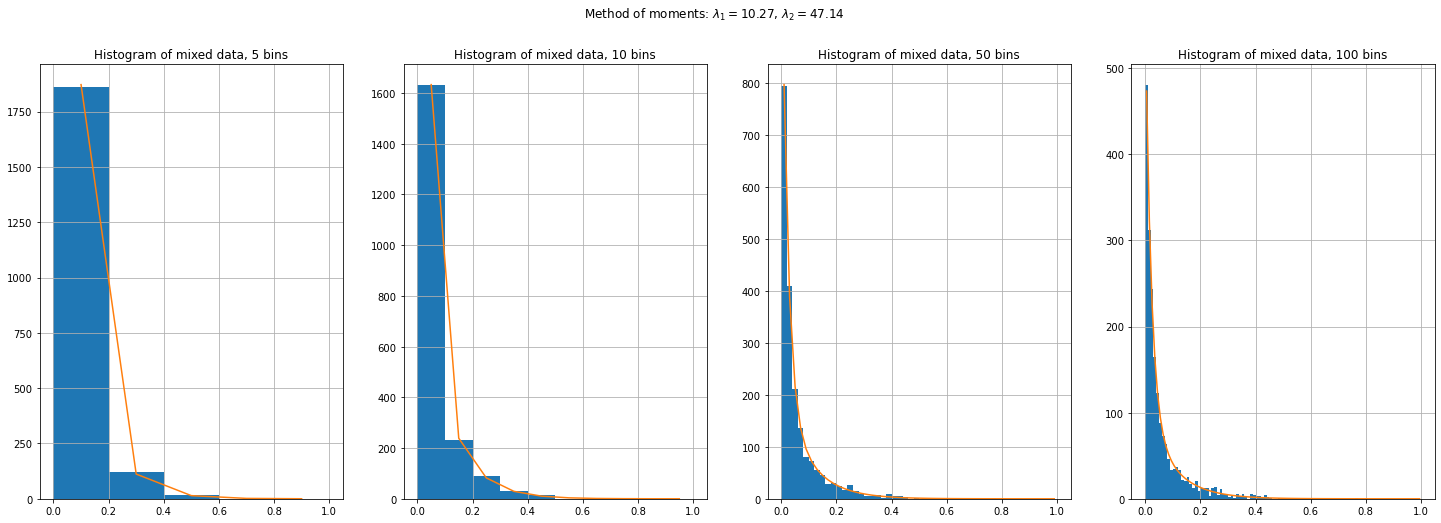

In [6]:
fig = plt.figure(figsize=(25,8))
axs = fig.subplots(1, 4)
fig.suptitle(r'Method of moments: $\lambda_1=%.2f$' % (lambda1, ) + ', $\lambda_2=%.2f$' % (lambda2, ))

for hist, bin_edges, ax in zip(histograms_list, bin_edges_list, axs):
  bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
  ax.hist(bin_edges[0:-1], bin_edges, weights=hist, label='Data')
  ax.plot(bin_centers, 2000*bin_probability(double_expo, bin_edges, [lambda1, lambda2], integrate=True), label=r'$0.5(\lambda_1e^{-\lambda_1 x} + \lambda_1e^{-\lambda_1 x}$')
  ax.set_title("Histogram of mixed data, {} bins".format(len(bin_edges)-1))
  ax.grid(True)

The method of moments has successfully provided parameters which seem to be in good agreement with the generated data.

## $\chi^2$ minimization
Let's now try to use the Lest Chi Square method to estimate the parameters of our distribution.

In [7]:
def residuals_sum(parameters, pdf, histogram, bin_edges, uncertainties=None, integrate=False, standard_uncertainty=True):
  '''
  Compute the residulas of the histogram given a pdf. The uncertainties can be passed to the function. If no uncertainties
  are given it is possible to compute them according to a Poisson distribution or set them all to 1.

  Parameters:
  -----------
  parameters: (list) parameters to passed to the pdf
  pdf: (callable obj) probability denisity function
  histogram: (array) number of observed occurences in each bin
  bin_edges: (array) edges of the bins of the histogram
  uncertainties: (array) uncertainty of each bin
  integrate (bool) if True the pdf is integrated over each bin to find the probability
                   if False the probability is approximated as the value of the pdf at the center of the bin times the bin width
  standard_uncertainty: (bool) used only if uncertainties are not explicetly given. If True they are extimated as sqrt(histogram) if False they are set to 1

  Returns:
  --------
  (float) differences between expected and observed values, scaled by uncertainties
  '''
  amplitude = parameters[0]
  pdf_parameters = parameters[1:]
  non_zero_index = histogram != 0

  non_zero_histogram = histogram[non_zero_index]
  non_zero_bin_probabilities = bin_probability(pdf, bin_edges, pdf_parameters, integrate)[non_zero_index]

  if uncertainties is None:
    if standard_uncertainty == True:
      sigmas = np.sqrt(non_zero_histogram)
    else:
      sigmas = 1
  else:
    sigmas = uncertainties[non_zero_index]

  residuals_sum = np.sum(((non_zero_histogram - amplitude * non_zero_bin_probabilities) / sigmas)**2)

  return residuals_sum

print(residuals_sum([2000,10, 50], double_expo, histograms_list[3], bin_edges_list[3])) # checking if the residuals_sum function work

61.29693751803441


The $\chi^2$ of the histogram with 100 bins, computed with the real values of $\lambda_1$ and $\lambda_2$ is approximately 60 (the exact value will change every time a new sample is generated). Considering that the parameters were known, it is close enough to the expected value of 100.

In [8]:
def minimize_chi2_and_plot(histograms_list, bin_edges_list, starting_parameters=[2000, 10, 50], integrate=False, standard_uncertainty=True):
  '''
  Given a histogram, this function try to estimate the parameters of the double exponential distribution minimizing the Chi2.
  The method of integration of the pdf over the bins and the treatment of uncertainties are the same of the function residuals_sum.

  Parameters:
  -----------
  hisograms_list: (list of arrays) list of histograms (number of observed occurences in each bin)
  bin_edges_list: (list of arrays) list of bin edges of the histogram
  starting_parameters: (list) parameters at the beginning of the minimization process
  integrate: (bool) passed to the residual_sum function (see function definition). The same value is used for plotting the pdf over the histogram.
  standard_uncertainty: (bool) passed to the residual_sum function (see function definition)
  '''

  fig = plt.figure(figsize=(25,8))
  assert(len(histograms_list) == len(bin_edges_list)) # check that the list of histograms and bin edges have the same length
  N = len(histograms_list)                            # number of histograms
  axs = fig.subplots(1, N)

  for hist, bin_edges, ax in zip(histograms_list, bin_edges_list, axs):
    # if the histogram has more than 10 bins the integration take too much time
    # without relevant improvements in fit quality
    if integrate == True and len(hist) > 10:
      break

    chi2_result = sp.optimize.minimize(residuals_sum, starting_parameters,
                                       args=(double_expo, hist, bin_edges, None, integrate, standard_uncertainty),
                                       bounds = [(1900, 2100), (1, 20), (1, 100)])
    fit_parameters = chi2_result.x
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    ax.hist(bin_edges[0:-1], bin_edges, weights=hist)
    ax.plot(bin_centers, fit_parameters[0] * bin_probability(double_expo, bin_edges, fit_parameters[1:], integrate=integrate))
    ax.set_title("Chi2 fit, {} bins".format(len(bin_edges)-1))
    ax.grid(True)

    # create a text box with the value of lambda1 and lambda2
    textstr = '\n'.join((
      'amp=%.2f' % (fit_parameters[0], ),
      r'$\lambda_1=%.2f$' % (fit_parameters[1], ),
      r'$\lambda_2=%.2f$' % (fit_parameters[2], )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.6, 0.95, textstr, transform=ax.transAxes, fontsize=14,
          verticalalignment='top', bbox=props)

We first apply the method of least $\chi^2$ without uncertainties and not integrating the pdf over the bins

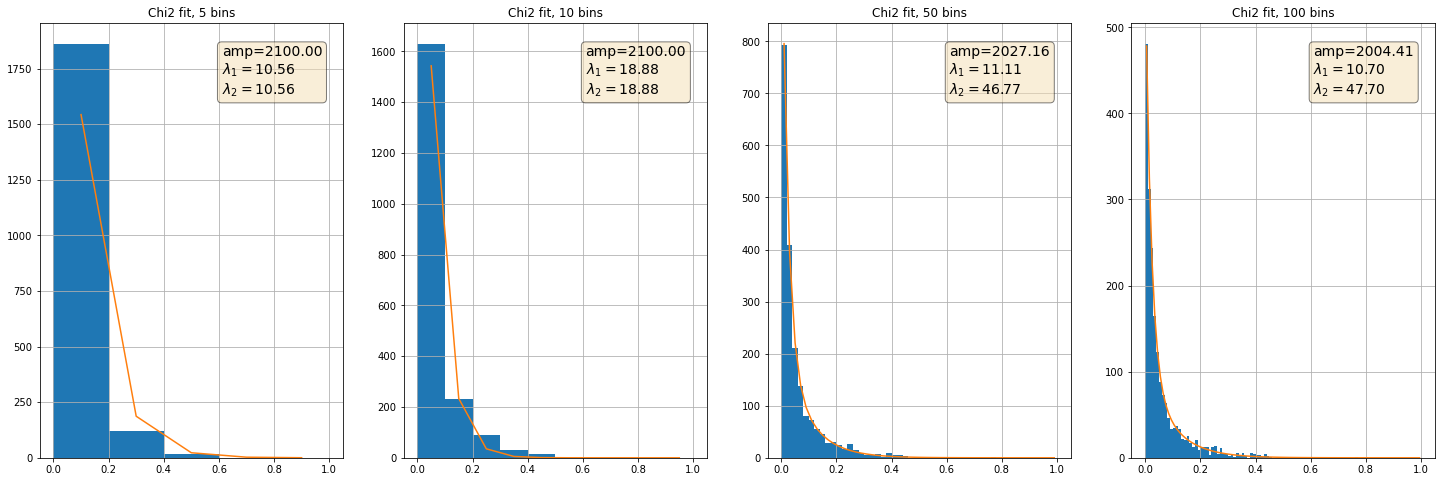

In [9]:
minimize_chi2_and_plot(histograms_list, bin_edges_list, [2000, 10, 50], integrate=False, standard_uncertainty=False)

Then we take uncertainties into account

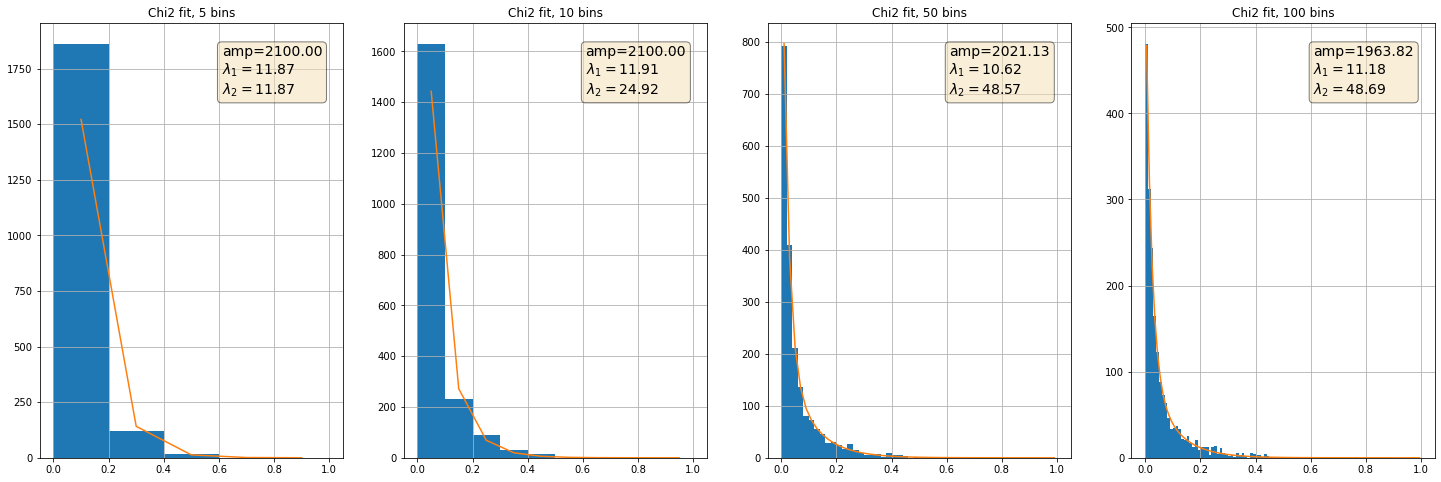

In [10]:
minimize_chi2_and_plot(histograms_list, bin_edges_list, [2000, 10, 50], integrate=False, standard_uncertainty=True)

We can also try to change the initial parameters to $\lambda_1 = \lambda_2 = 1$

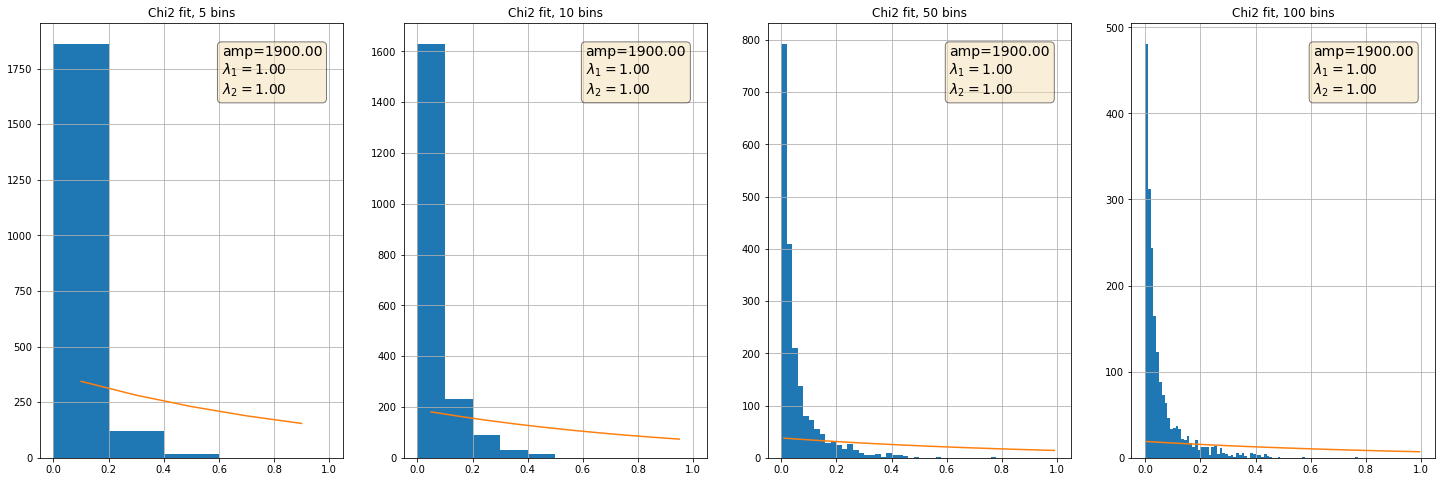

In [11]:
minimize_chi2_and_plot(histograms_list, bin_edges_list, [2000, 1, 1], integrate=False, standard_uncertainty=True)

Lastly, we integrate the pdf over the bins. The integration is applied only for histograms with less than 10 bins. Otherwise the computation time would be too big, without no relevant improvements in fit quality.

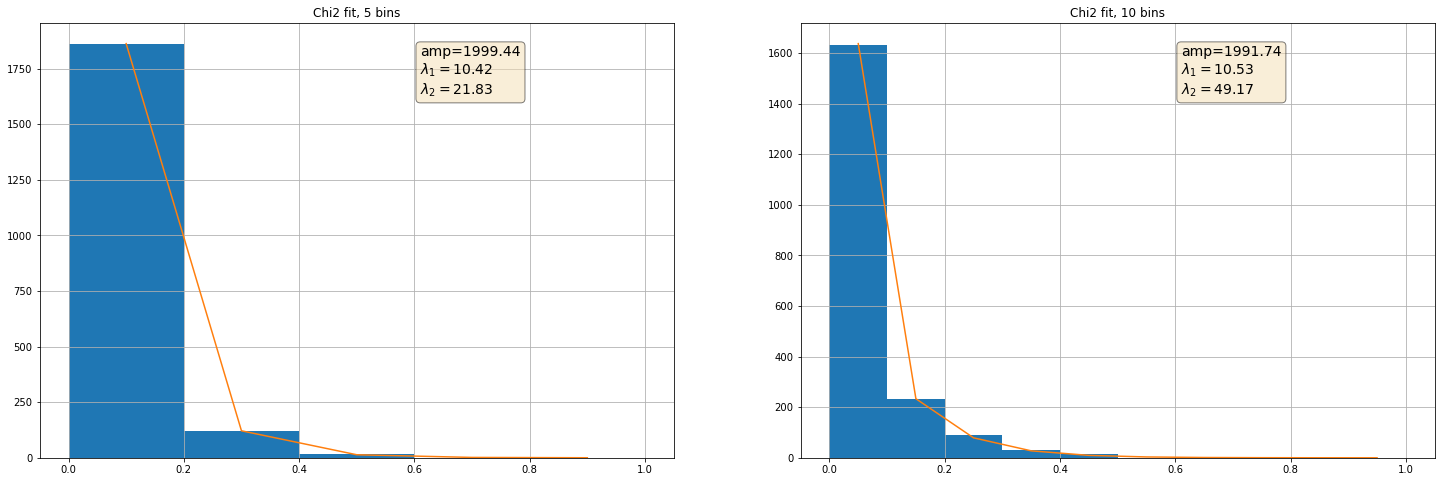

In [12]:
minimize_chi2_and_plot(histograms_list[:2], bin_edges_list[:2], [2000, 10, 50], integrate=True, standard_uncertainty=True)

#### Discussion
We can begin the discussion by analyzing the histograms with 5 and 10 bins. It is clear from the plots that without integrating over the bin, the minimization fails. The bin width is too large and the minimization process cannot succeed. Integrating over the bins improve the result of the histogram with 10 bins, which is close to the expected one. However the fit of the first histogram fails again. This is not surprising since fitting a 3-parameters function on a 5-bins histogram results in a 2 degree of freedom $\chi^2$ distribution, too few to successfully fit the data.

The 50 and 100 bins histograms perform better. The result is in agreement with the expectations even approximating the probabilities of the bins. Comparing the first fit (which does not take errors into accounts) with the second, we notice that $\lambda_1$ and $\lambda_2$ slightly change. The reason is that the second fit weights the residual of each bin differently. In particular the first bins, with more occurrences, have a bigger uncertainty and so a smaller weight.

If the initial conditions are set to (1,1) instead of (10,50) all the fits fail. This means that choosing initial conditions close to the expected value is crucial for the success of the fit.

### Maximum likelihood
We can now move to a new fitting technique, the maximum likelihood method. We begin by defining the functions necessary to compute the probability of obtaining a given histogram from a particular distribution. Next, we maximize this probability varying the parameters of the distribution.

In [13]:
def minus_loglikelyhood(parameters, pdf, histogram, bin_edges, integrate=False):
  '''
  This function computes the likelyhood of randmoly obtaining a particular histogram given the parameters of a pdf.
  The total likelyhood is the product of the probability of each bin. Since we want to maximize the likelyhood, we
  can compute its logarithm and maximize it instead (the logarithm is a monotonic function). The result is given
  with the opposite sign in order to use a minimization algorithm instead of a maximization one.

  Parameters:
  -----------
  parameters: (list) parameters to passed to the pdf
  pdf: (callable obj) probability denisity function
  histogram: (array) number of observed occurences in each bin
  bin_edges: (array) edges of the bins of the histogram
  integrate (bool) if True the pdf is integrated over each bin to find the probability
                   if False the probability is approximated as the value of the pdf at the center of the bin times the bin width

  Returns:
  --------
  (float) -sum(log(likelyhood of each bin))
  '''

  probabilities = bin_probability(pdf, bin_edges, parameters, integrate)
  loglikelyhood = np.sum(histogram * np.log(probabilities))

  return -loglikelyhood

def maximize_likelyhood_and_plot(histograms_list, bin_edges_list, starting_parameters=[10, 50], integrate=False):
  '''
  Given a histogram, this function try to estimate the parameters of the double exponential distribution maximizing the likelyhood
  of randomly obtaining this particular histogram. The method of integration of the pdf over the bins and the treatment of uncertainties
  are the same of the function residuals_sum.

  Parameters:
  -----------
  hisograms_list: (list of arrays) list of histograms (number of observed occurences in each bin)
  bin_edges_list: (list of arrays) list of bin edges of the histogram
  starting_parameters: (list) parameters at the beginning of the minimization process
  integrate: (bool) passed to the residual_sum function (see function definition). The same value is used for plotting the pdf over the histogram.
  standard_uncertainty: (bool) passed to the residual_sum function (see function definition)
  '''                               
  fig = plt.figure(figsize=(25,8))
  assert(len(histograms_list) == len(bin_edges_list)) # check that the list of histograms and bin edges have the same length
  N = len(histograms_list)                            # number of histograms
  axs = fig.subplots(1, N)

  for hist, bin_edges, ax in zip(histograms_list, bin_edges_list, axs):
    # if the histogram has more than 10 bins the integration take too much time
    # without relevant improvements in fit quality
    if integrate == True and len(hist) > 10:
      break

    likelyhood_result = sp.optimize.minimize(minus_loglikelyhood, starting_parameters,
                                       args=((double_expo, hist, bin_edges, integrate)), 
                                       bounds=[(1, None), (1, None)])
    
    fit_parameters = likelyhood_result.x
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    ax.hist(bin_edges[0:-1], bin_edges, weights=hist)
    ax.plot(bin_centers, 2000 * bin_probability(double_expo, bin_edges, fit_parameters, integrate=integrate))
    ax.set_title("Max likelyhood fit, {} bins".format(len(bin_edges)-1))
    ax.grid(True)

    # create a text box with the value of lambda1 and lambda2
    textstr = '\n'.join((
      r'$\lambda_1=%.2f$' % (fit_parameters[0], ),
      r'$\lambda_2=%.2f$' % (fit_parameters[1], )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.6, 0.95, textstr, transform=ax.transAxes, fontsize=14,
          verticalalignment='top', bbox=props)

We first apply the maximum likelihood method without integrating the pdf over the bins

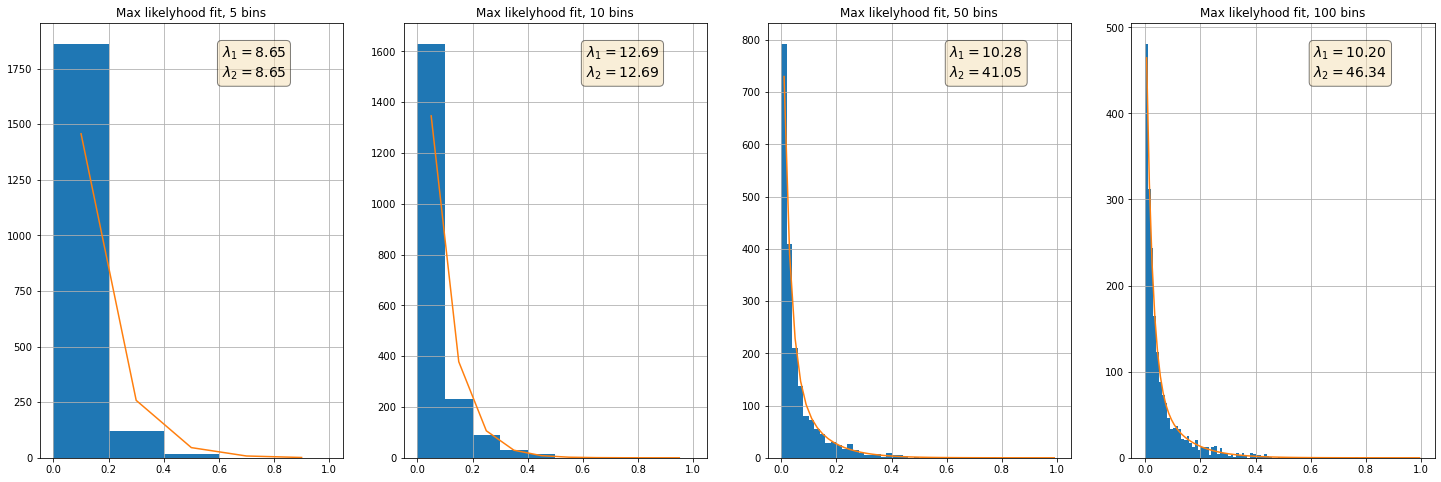

In [14]:
maximize_likelyhood_and_plot(histograms_list, bin_edges_list, [10, 50], integrate=False)

Then we integrate the pdf over the bins. This is done only for the histograms with less than 10 bins. With more bins, the computational time is too big without any significant improvement in fit quality.

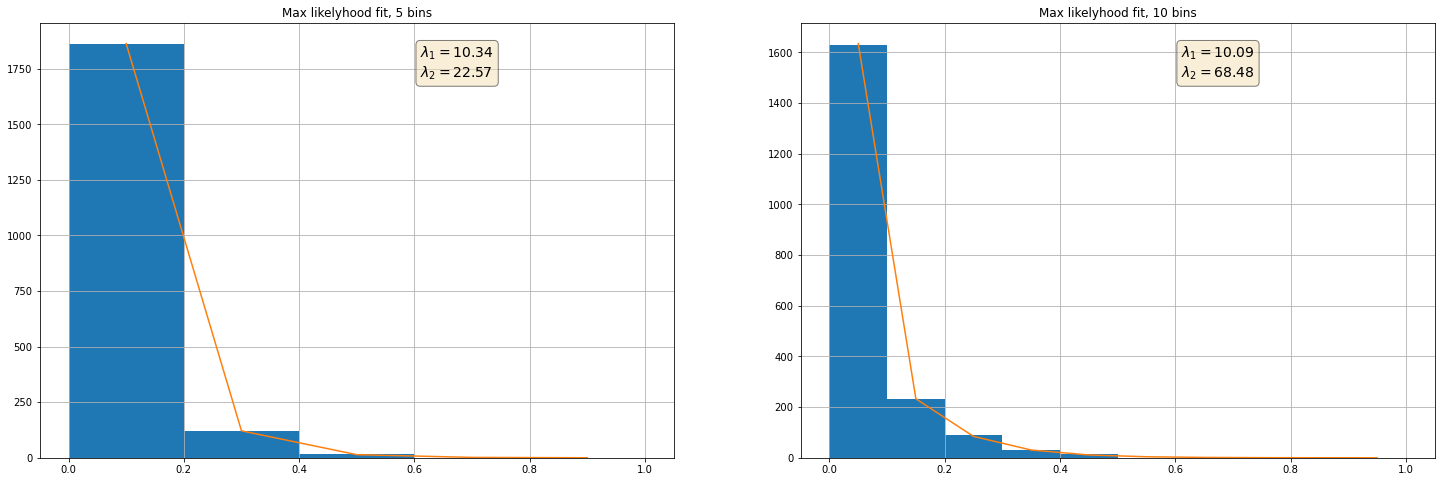

In [15]:
maximize_likelyhood_and_plot(histograms_list[:2], bin_edges_list[:2], [10, 50], integrate=True)

#### Discussion
Performing the integration, the quality of the fit on the histograms improves. Now both the fit succeed. Moreover, they are also better than the result of the $\chi^2$ method. A possible reason is that the maximum likelihood method does not need an amplitude parameter. This leaves (for the first histogram) 3 degree of freedom instead of 2. The fit quality is still better in the histograms with  more bins. However, if the only available data is aggregated in few bins, the maximum likelihood method is to be preferred to the minimization of the $\chi^2$. In fact, even if the function is in good agreement with the histograms, the parameters are far frome the right ones.

## Fitting and interpretation

### Importing and visualizing the data
We begin by reading the datasets and plotting it in histograms to visualize the data we have

In [16]:
import pandas as pd       # import the dataset

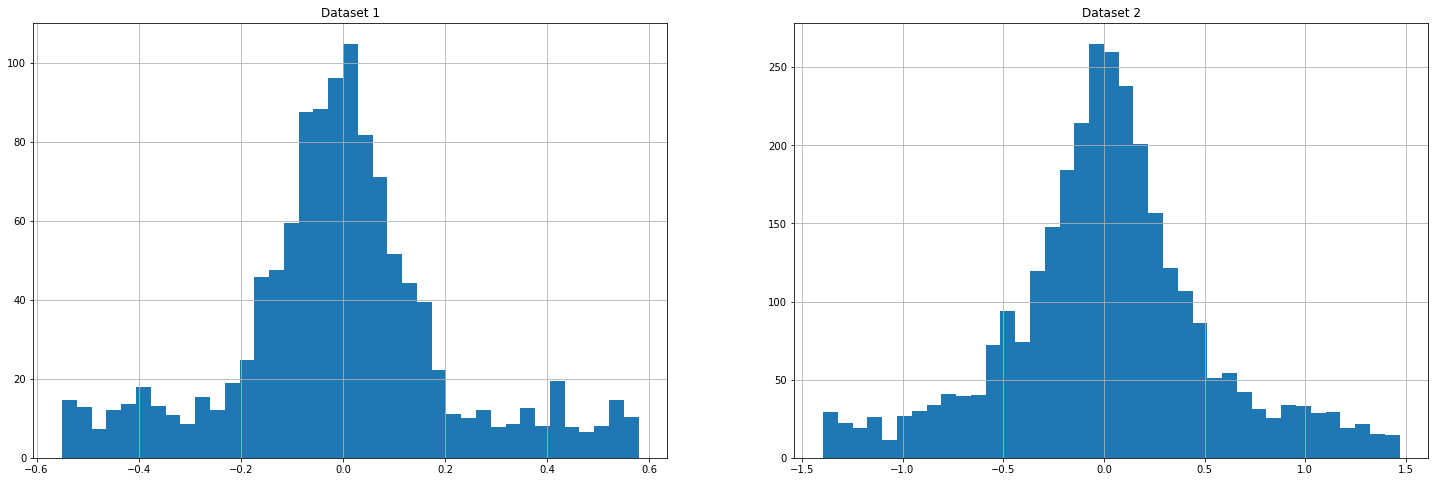

In [17]:
# importing the data in a pandas dataframe
dataframes = [pd.read_csv('Project-3_data_set_{}.dat'.format(i), delimiter='  ', names=['X', 'Y', 'dY'], engine='python', header=1)
              for i in range(1,3)]

# creating three lists of numpy arrays, every list has an array for each dataset
histograms_list = [df.Y.to_numpy() for df in dataframes]
bin_centers_list = [df.X.to_numpy() for df in dataframes]
errors_list = [df.dY.to_numpy() for df in dataframes]

def find_bin_edges(bin_centers):
  '''
  Find the bin edges of a histogram given the bin centers.

  Parameters:
  -----------
  bin_centers: (array of dim N) centers of the bins

  Returns:
  --------
  bin_edges: (array of dim N+1) edges of the bins
  '''

  half_bin_widths = (bin_centers[1:] - bin_centers[:-1]) / 2
  bin_edges = bin_centers[:-1] + half_bin_widths
  first_bin_edge = bin_centers[0] - half_bin_widths[0]
  last_bin_edge = bin_centers[-1] + half_bin_widths[-1]
  bin_edges = np.append(first_bin_edge, bin_edges)
  bin_edges = np.append(bin_edges, last_bin_edge)

  return bin_edges

bin_edges_list = [find_bin_edges(bin_centers) for bin_centers in bin_centers_list]

# plotting the histograms
fig = plt.figure(figsize=(25,8))
axs = fig.subplots(1, 2)
axs[0].set_title('Dataset 1')
axs[1].set_title('Dataset 2')

for hist, bin_edges, bin_centers, ax in zip(histograms_list, bin_edges_list, bin_centers_list, axs):
  ax.hist(bin_edges[0:-1], bin_edges, weights=hist, label='Data')
  ax.grid()


We can see that the data are shaped according to a bell curve. The non-zero bins at the edges suggest the presence of some random noise. We can try to fit different functions, which may be linked to different theories that may explain the data. In particular we are fitting the data with the convolution of two Gaussian (which is a Gaussian itself with $\mu = \mu_1 + \mu_2$ and $\sigma^2 = \sigma_1^2 + \sigma_2^2$), the convolution of a Gaussian and a Lorentzian (which is called a Voigtian) and with a Voigtian combined with a smooth background. The background is rendered with a first degree polynomial, in particular with a linear combination of the first two Legendre polynomials. Polynomials of degree 2 were tried too, but they overfitted the histogram.

### Fitting
We begin by defining the functions of the distributions we are interested in.

In [18]:
def noise_pdf(x, parameters):
  '''
  PDF of noise. The noise is modelled as a polynomial of degree 1. The polynomial is defined as
  the sum of the first 2 Legendre polynomials. The result is a smooth function with low
  fluctuations in the range of the signal.

  Parameters:
  -----------
  x: (float, array) point(s) where to evauate the noise
  parameters: (iterable of length 3) coefficitents of the first three Legendre polynomials

  Return:
  -------
  noise: (float, array) noise in x
  '''

  noise0 = parameters[0]
  noise1 = parameters[1]
  noise = noise0 + noise1*sp.special.legendre(1)(x)
  return noise

def voigtian(x, parameters):
  '''
  Voigtian pdf (convolution of a Gaussian and a Lorentzian)

  Parameters:
  -----------
  x: (float, array) point(s) where to evauate the voigtian
  parameters: (iterable of length 2) parameters of the voigtian [sigma, gamma]

  Return:
  -------
  voigt: (float, array) voigtian in x
  '''
  sigma = parameters[0]
  gamma = parameters[1]
  voigt = sp.special.voigt_profile(x, sigma, gamma)
  return voigt

def noise_voigtian(x, parameters):
  '''
  Voigtian pdf (convolution of a Gaussian and a Lorentzian) plus noise. The noise is modelled as a polynomial of degree 2. The polynomial is defined as
  the sum of the first 3 Legendre polynomials. The result is a smooth function with low
  fluctuations in the range of the signal.

  Parameters:
  -----------
  x: (float, array) point(s) where to evauate the pdf
  parameters: (iterable of length 5) parameters of the voigtian [sigma, gamma] and the noise

  Return:
  -------
  voigt: (float, array) pdf in x
  '''

  voigt_pars = parameters[:2]
  noise_pars = parameters[2:]
  voigt = voigtian(x, voigt_pars)
  noise = noise_pdf(x, noise_pars)

  return voigt + noise

def noise_gaussian(x, parameters):
  '''
  Gaussian pdf plus noise. The noise is modelled as a polynomial of degree 2. The polynomial is defined as
  the sum of the first 3 Legendre polynomials. The result is a smooth function with low
  fluctuations in the range of the signal.

  Parameters:
  -----------
  x: (float, array) point(s) where to evauate the pdf
  parameters: (iterable of length 5) parameters of the voigtian [mu, sigma] and the noise

  Return:
  -------
  gauss: (float, array) pdf in x
  '''

  mu = parameters[0]
  sigma = parameters[1]
  noise_pars = parameters[2:]

  gauss = sp.stats.norm.pdf(x, loc=mu, scale=sigma)
  noise = noise_pdf(x, noise_pars)
  return gauss + noise

Then we fit all the pdfs minimizing the $\chi^2$ in the same way we did in the previous section

In [19]:
# defininge lists of the pdfs, pdfs names, initial parameters and bounds
# all the lists have the structure [Voigtian+noise, Gaussian, Voigtian]

pdfs_list = [noise_voigtian, noise_gaussian, voigtian]
pdfs_names = ['Voigtian + noise', 'Gaussian (convolution) + noise', 'Voigtian']

# the parameters of Voigtian+noise are [amp, sigma, gamma, noise0, noise1]
# the parameters of the Gaussian+noise are [amp, mu, sigma, noise0, noise1]
# the parameters of the Voigtian are [amp, sigma, gamma]

initial_parameters_list1 = [[800, 0.1, 0.01, 0.4, 0], [800, 0, 0.1, 0.4, 0], [800, 0.1, 0.02]]         # first histogram
initial_parameters_list2 = [[2000, 0.2, 0.03, 0.4, 0], [2000, 0, 0.2, 0.1, 0], [2000, 0.3, 0.1]]        # second histogram
initial_parameters_list = [initial_parameters_list1, initial_parameters_list2]                          # both histograms

# the bounds follow the same pattern
bounds_list = [[(500, None), (0.01, 1), (0, 1), (-1, 1), (-0.5, 0.5)], [(500, None), (-0.1, 0.1), (0.01, 1), (-1, 1), (-0.5, 0.5)], [(500, None), (0, 1), (0, 1)]]

# fit every pdf on both histograms with inital_parameters given by initial_parameters_list
fit_results = [[sp.optimize.minimize(residuals_sum, initial_parameters, args=(pdf, hist, bin_edges, err), bounds=bounds)
                for (pdf, initial_parameters, bounds) in zip(pdfs_list, initial_parameters_listn, bounds_list)]
               for (hist, bin_edges, err, initial_parameters_listn) in zip(histograms_list, bin_edges_list, errors_list, initial_parameters_list)]

Lastly we plot the histograms and the result of the fit. For the Voigtian + noise distribution we plot both the overall function and the noise alone. This way we can check that the noise has an acceptable shape, smooth in the region of the signal.

Text(0.5, 1.0, 'Dataset 2')

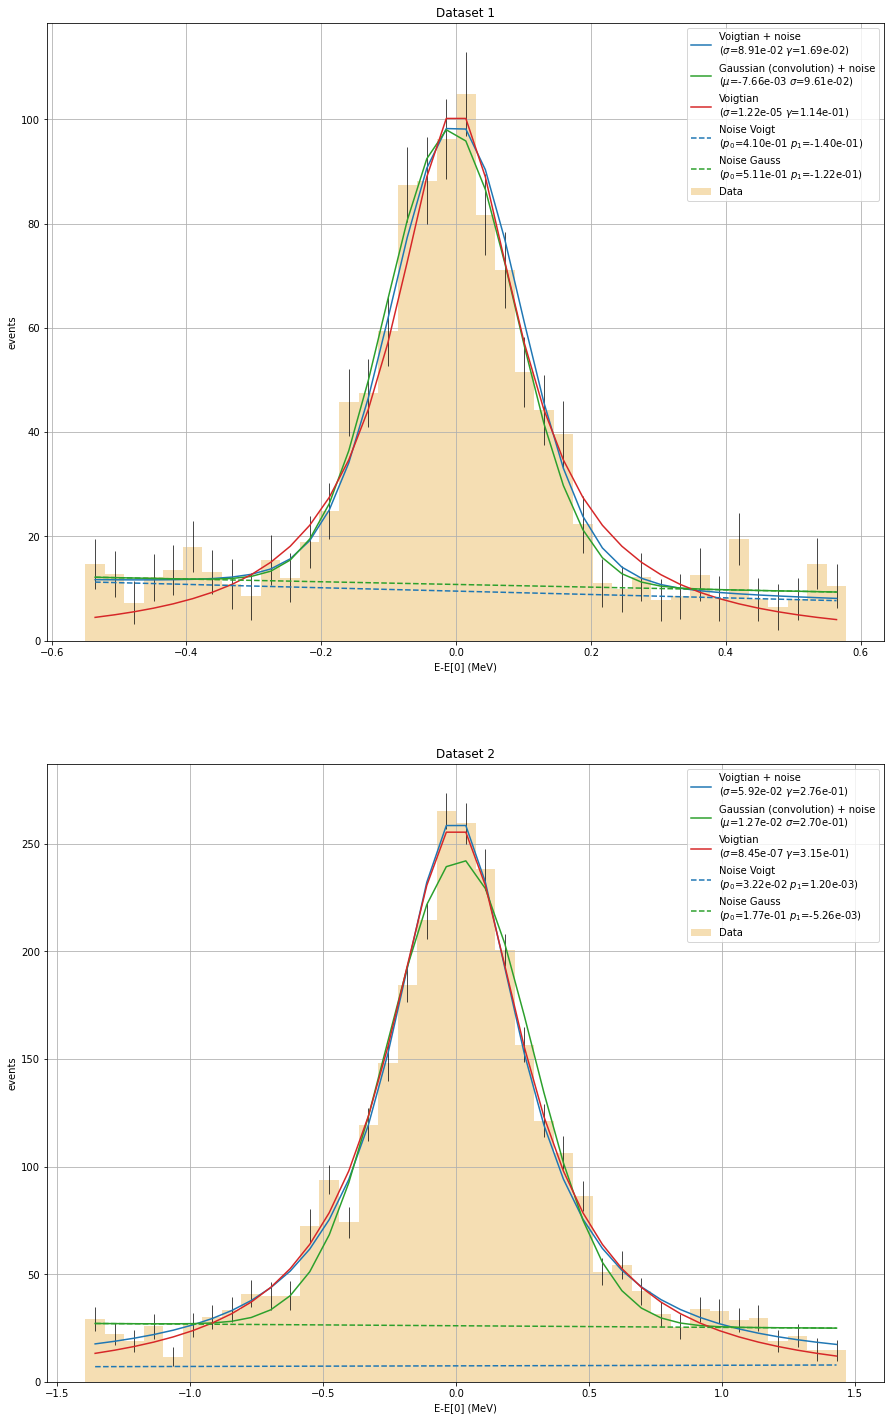

In [20]:
fig = plt.figure(figsize=(15,25))
axs = fig.subplots(2, 1)

for hist, bin_edges, err, bin_centers, fit_result, ax in zip(histograms_list, bin_edges_list, errors_list, bin_centers_list, fit_results, axs):
  ax.hist(bin_edges[0:-1], bin_edges, weights=hist, label='Data', color='wheat')
  ax.errorbar(bin_centers, hist, yerr=err, linestyle='', color='black', elinewidth=0.7)
  
  par_names_list = [['$\sigma$', '$\gamma$'], ['$\mu$', '$\sigma$'], ['$\sigma$', '$\gamma$']]
  colors = ['tab:blue', 'tab:green', 'tab:red',]
  for result, pdf, pdf_name, par_names, color in zip(fit_result, pdfs_list, pdfs_names, par_names_list, colors):
    parameters = result.x
    label = r'' + pdf_name + '\n('
    for par, par_name in zip(parameters[1:], par_names):
      label = label + par_name + '=' + '{:.2e}'.format(par) + ' '
    label = label[:-1] + ')'
    ax.plot(bin_centers, parameters[0] * bin_probability(pdf, bin_edges, parameters[1:]), label=label, color=color)

  def plot_noise(noise_pars, name, color):
    noise_label = r'' + name + '\n('
    for i in range(0, len(noise_pars)-3):
      noise_label = noise_label + '$p_{}$'.format(i) + '=' + '{:.2e}'.format(noise_pars[3+i]) + ' '
    noise_label = noise_label[:-1] + ')'
    ax.plot(bin_centers, noise_pars[0] * bin_probability(noise_pdf, bin_edges, noise_pars[3:]), label=noise_label, color=color, linestyle='--')

  plot_noise(fit_result[0].x, 'Noise Voigt', colors[0])
  plot_noise(fit_result[1].x, 'Noise Gauss', colors[1])
  ax.legend()
  ax.grid()
  ax.set_xlabel('E-E[0] (MeV)')
  ax.set_ylabel('events')

axs[0].set_title('Dataset 1')
axs[1].set_title('Dataset 2')

### Pearson test
To check the result, we perform a Pearson test on all the fitted distribution.

In [21]:
residuals = [[result.fun for result in hist_result] for hist_result in fit_results]
print('Residuals: ', residuals)
number_of_bins = [len(hist) for hist in histograms_list]
dofs = [[len(hist) - len(result.x) for result in hist_result] for (hist_result, hist) in zip (fit_results, histograms_list)]
print('Dof:', dofs)
chi2_distributions = [[sp.stats.chi2(dof) for dof in dof_list] for dof_list in dofs]
p_left_right = [[(chi2.cdf(x), 1-chi2.cdf(x)) for (chi2, x) in zip(hist_chi2_distributions, hist_residuals)] for (hist_chi2_distributions, hist_residuals) in zip(chi2_distributions, residuals)]

print()
for i in range(2):
    print('Histogram {}'.format(i+1))
    for pdf, pdf_name in zip(p_left_right[i], pdfs_names):
        print(' ', pdf_name)
        print('  P_left = {:.2f}'.format(pdf[0]), ' P_right = {:.2f}'.format(pdf[1]))

Residuals:  [[27.159336411158456, 22.47106652513365, 56.06652813913574], [57.07820220911766, 93.83295963587864, 67.91015466992144]]
Dof: [[34, 34, 36], [34, 34, 36]]

Histogram 1
  Voigtian + noise
  P_left = 0.21  P_right = 0.79
  Gaussian (convolution) + noise
  P_left = 0.07  P_right = 0.93
  Voigtian
  P_left = 0.98  P_right = 0.02
Histogram 2
  Voigtian + noise
  P_left = 0.99  P_right = 0.01
  Gaussian (convolution) + noise
  P_left = 1.00  P_right = 0.00
  Voigtian
  P_left = 1.00  P_right = 0.00


#### Discussion
##### First dataset
From the first plot we can see that the distribution that best fit the histogram is either the Voigtian + noise or the Gaussian + noise. This is confirmed by the Perason test, which return a (left) P value of 0.21 for the  first and 0.07 for the second. This means that the probability of having worse data is respectively 0.79 and 0.93. Both are greater than the standard limit of 0.05. The test gives negative result for the other distribution (Voigtian without noise). We can then conclude that the most likely hypothesis is that the data follow a Gaussian distribution with $\sigma = 0.096$.

#### Second dataset
From the second plot it is not clear which distribution is the right one. The Pearson test in this case is negative for every pdf. The left P value is 0.99 for the Voigtian + noise distribution and 1.00 for the Gaussian + noise pdf. So there is respectively a 0.01 and 0.00 probability of the data to fit worse. After many attempts we have not been able to succeed to fit the histogram with any of the distributions. One possible reason may be found in the different errors of the data. We can try to analyse them with more attention.

In [22]:
for hist, err in zip(histograms_list, errors_list):
    rel_err = err / np.sqrt(hist)
    print(rel_err)
    menam_rel_err = np.mean(rel_err)
    print(menam_rel_err)

[1.24261916 1.24657621 1.53232842 1.29426962 1.29001249 1.14247833
 1.17102457 1.45493905 1.55052406 1.22538227 1.36993285 1.14405362
 1.08084623 0.94861952 0.9526007  0.85845095 0.77826287 0.88686764
 0.78643689 0.78825961 0.85624279 0.87037968 0.94459101 1.0118298
 1.02664721 1.15748233 1.40091613 1.39777945 1.32196635 1.45057347
 1.50123721 1.44074255 1.5154917  1.13894254 1.45655524 1.72917536
 1.41010924 1.27493812 1.31075502]
1.2041241092782566
[1.06147159 1.08284288 1.15683792 1.14397872 1.34241792 1.10485076
 1.02258414 0.99082912 0.9910166  1.00854257 1.07237265 0.94034404
 0.69636797 0.81711884 0.70304008 0.69053831 0.58261785 0.59407238
 0.50727585 0.5883457  0.60994854 0.52950387 0.66395374 0.71014025
 0.75691209 0.73841168 0.87182058 0.87391789 0.98821847 1.02314683
 1.13433356 0.99293051 0.98655484 1.06112879 1.10473884 1.18521469
 1.16278484 1.36398509 1.28504968]
0.9266707865679168


We can see that if we compute the ration between the given errors and the standard error (equal to square root of entries), the first dataset has bigger uncertainties than the second. In particular, the mean of the relative errors is respectively 1.20 and 0.93. A smaller error results in bigger residuals, and so in a smaller right P value.